In [1]:
from importlib import reload
import sys, os
from copy import deepcopy
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy as sp
import scipy.stats as st
print('scipy version %s' % sp.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
print('matplotlib version %s' % matplotlib.__version__)

python version 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
numpy version 1.26.4
scipy version 1.14.1
pandas version 2.2.2
matplotlib version 3.9.2


In [2]:
SIMULATION_DIRECTORY = 'simulations'
DATA_DIRECTORY       = 'data'
SCRIPT_DIRECTORY     = ''
INFERENCE_DATE       = '2022-06-09'
SARS_DATA_DIR        = os.path.join(os.getcwd(), DATA_DIRECTORY)

In [12]:
df = pd.read_csv(os.path.join(DATA_DIRECTORY, 'old-mutation-comparison-04-2024.csv'))

df_comp = df[df['new rank']<51]

df_comp_old = df_comp[df_comp['old rank']<51]
old_order = np.argsort(np.array(df_comp_old['old rank']))
print('still in top 50 (%d total)' % len(df_comp_old))
print('old\tnew')
for i in old_order:
    entry = df_comp_old.iloc[i]
    print('%d\t%d' % (entry['old rank'], entry['new rank']))

df_comp_out = df_comp[df_comp['old rank']>50]
out_order = np.argsort(np.array(df_comp_out['old rank']))
print('\nwas out of top 50 (%d total)' % len(df_comp_out))
print('old\tnew')
for i in out_order:
    entry = df_comp_out.iloc[i]
    print('%d\t%d' % (entry['old rank'], entry['new rank']))

old_ranks = np.unique(df_comp_old['old rank'])
dropped_ranks = [i for i in range(1, 51) if i not in old_ranks]
df_dropped = df[df['old rank'].isin(dropped_ranks)]
dropped_order = np.argsort(np.array(df_dropped['old rank']))
print('\nno longer in top 50 (%d total)' % len(df_dropped))
print('old\tnew')
for i in dropped_order:
    entry = df_dropped.iloc[i]
    print('%d\t%d' % (entry['old rank'], entry['new rank']))

still in top 50 (28 total)
old	new
1	4
2	5
3	8
4	2
6	34
7	10
9	50
10	46
11	29
13	32
14	11
16	15
18	25
19	22
21	7
22	23
25	39
26	16
27	6
28	40
29	30
30	12
31	37
32	41
35	47
37	17
38	45
40	33

was out of top 50 (9 total)
old	new
55	44
94	20
111	28
122	31
207	24
214	9
262	38
468	27
1180	26

no longer in top 50 (24 total)
old	new
5	834
5	57
8	60
12	128
15	112
17	92
20	56
23	87
33	71
36	73
39	204
41	74
41	721
41	723
42	78
43	67
44	193
45	570
46	107
47	813
47	268
47	790
48	458
50	121


In [7]:
# df = pd.read_csv(os.path.join(DATA_DIRECTORY, 'detection-merged-4-2024b.csv'), memory_map=True)
# print(np.unique(df['variants_match'].astype(str)))

# Make table for detection events

# match2str = {'[]': '', 'alpha': 'Alpha', 'b1': 'B.1', 'b1-alt': 'B.1', 'ba.1': 'Omicron (BA.1)', 
#              'ba.2': 'Omicron (BA.2)', 'ba.4': 'Omicron (BA.4)', 'beta': 'Beta', 'delta': 'Delta', 
#              'epsilon': 'Epsilon', 'eu1': 'EU1', 'gamma': 'Gamma', 'iota': 'Iota', 'kappa': 'Kappa', 
#              'lambda': 'Lambda', 'mu': 'Mu', 'nan': ''}

import datetime as dt

pre = '''\\clearpage
{
\\scriptsize
\\begin{longtable}{ p{1.2cm} p{8cm} p{1cm} p{2cm} p{4cm} }
\\toprule
Time & Mutation(s) & Selection & Location & Overlapping \\\\ 
     & (protein-codon-index-nucleotide) &     (\\%) &          & variants \\\\
\\bottomrule'''

post = '''\\caption{\\textbf{Table of detected high growth (HG) variants.} 
Note that detection events in different regions are independent. Identified HG SNVs are 
``true positives'' if they are associated with major variants, and ``false positives'' otherwise. 
Events here use a threshold of 18.5\\% for classifying SNVs as HG. The ``Overlapping variant(s)'' column
lists the major variant(s) in which some of the HG SNVs appear. If no variant is listed,
then these SNVs do not appear in any major variants.}
\\label{table:groups}
\\end{longtable}'''

endline = '\\\\ \\hline\n'

df = pd.read_csv(os.path.join(DATA_DIRECTORY, 'detection-merged-04-2024b.csv'), memory_map=True)
t_sort = np.argsort(df['time'])

f = open('table.dat', 'w')
f.write('%s\n' % pre)

for idx in t_sort:
    df_entry = df.iloc[idx]
    t = str(dt.timedelta(days=int(df_entry['time'])) + dt.datetime(2020,1,1)).split()[0]
    mut = str(df_entry['group']).split()
    for i in range(len(mut)):
        if mut[i].split('-')[0]!='NC':
            mut[i] = mut[i].split('-')
            mut[i][2] = '%d' % (int(mut[i][2])+1)
            mut[i] = '-'.join(mut[i])
    mut = ' '.join(mut)
    s = '%.2f' % float(df_entry['selection'])
    loc = str(df_entry['region']).replace('_', '-')
    if 'groups.cs' in loc:
        loc = '-'.join(loc.split('-')[:-2])
    # var = match2str[str(df_entry['variants_match'])]
    var = str(df_entry['variants_associated'])
    if var in ['None', 'nan']:
        var = ''
    f.write('%s & %s & %s & %s & %s %s' % (t, mut, s, loc, var, endline))

f.write('%s\n' % post)
f.close()

# Figures for paper

In [20]:
df_temp = pd.read_csv('gisaid_variants_statistics.tsv', sep='\t')
df_temp.head()

,Country,Week prior to,Type,Value,Submission Count,% per Country and Week,Total per Country and Week
0,Afghanistan,2020-05-31,Clade,GH,1,0.5,2
1,Afghanistan,2020-05-31,Clade,G,1,0.5,2
2,Afghanistan,2020-05-31,Variant,Other,2,1.0,2
3,Afghanistan,2020-05-31,AA-Subst,Spike_D614G,2,1.0,2
4,Afghanistan,2020-06-07,Clade,GH,2,0.5,4


In [29]:
df_var= df_temp[df_temp.Type=='Variant']
print(np.unique(list(df_var.Value)))

tags = ['Former VOC Alpha GRY (B.1.1.7+Q.*) first detected in the UK',
        'Former VOC Delta GK (B.1.617.2+AY.*) first detected in India',
        'Former VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa',
        'VOI GRA (XBB.1.5+XBB.1.5.*) first detected in Austria/India/Bangladesh']
labels = ['Alpha', 'Delta', 'Omicron (BA.1)', 'XBB.1.5']

import datetime as dt

t_ref = dt.datetime(2020,1,1)
def date2days(date):
    year, month, day = tuple(np.array(date.split('-'), int))
    t = dt.datetime(year, month, day)
    return 1 + (t - t_ref).days

col_loc   = 'Country'
col_total = 'Total per Country and Week'
col_freq  = '% per Country and Week'
col_date  = 'Week prior to'

df_list = [df_var[df_var['Value']==t] for t in tags]

['Former VOC Alpha GRY (B.1.1.7+Q.*) first detected in the UK'
 'Former VOC Beta GH/501Y.V2 (B.1.351+B.1.351.2+B.1.351.3) first detected in South Africa'
 'Former VOC Delta GK (B.1.617.2+AY.*) first detected in India'
 'Former VOC Gamma GR/501Y.V3 (P.1+P.1.*) first detected in Brazil/Japan'
 'Former VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa'
 'Former VOI Epsilon GH/452R.V1 (B.1.429+B.1.427) first detected in USA/California'
 'Former VOI Eta G/484K.V3 (B.1.525) first detected in UK/Nigeria'
 'Former VOI Iota GH/253G.V1 (B.1.526) first detected in USA/New York'
 'Former VOI Kappa G/452R.V3 (B.1.617.1) first detected in India'
 'Former VOI Lambda GR/452Q.V1 (C.37+C.37.1) first detected in Peru'
 'Former VOI Mu GH (B.1.621+B.1.621.1) first detected in Colombia'
 'Former VOI Theta GR/1092K.V1 (P.3) first detected in the Philippines'
 'Former VOI Zeta GR/484K.V2 (P.2) first detected in Brazil'
 'Former VUM GH/490R (B.1.640+B.1.640.*) first detected in

In [30]:
c_min   = 20
max_gap = 10
run_min = 4

f = open('temp-trajectories.csv', 'w')
f.write('location,times,frequencies,variant_names\n')

for i in range(len(labels)):
    df = df_list[i]
    df = df[df[col_total]>=c_min] # immediately enforce min count
    times_days = [date2days(date) for date in df[col_date]]
    df['time'] = times_days

    # Iterate by country > time
    countries = np.unique(df[col_loc])
    for c in countries:
        df_sub = df[df[col_loc]==c]
        times  = np.sort(np.array(df_sub['time']))

        temp_times = []
        temp_freqs = []
        for j in range(len(times)):
            df_sub_t = df_sub[df_sub['time']==times[j]]
            if (len(temp_times)==0) or ((times[j]-temp_times[-1])<max_gap):
                temp_times.append(times[j])
                temp_freqs.append(df_sub_t.iloc[0][col_freq])
            elif len(temp_times)>=run_min:
                f.write('%s,%s,%s,%s\n' % (c, ' '.join([str(_time) for _time in temp_times]), 
                                          ' '.join([str(_freq) for _freq in temp_freqs]), labels[i]))
                temp_times = []
                temp_freqs = []
            else:
                temp_times = []
                temp_freqs = []

f.close()

/var/folders/s6/r0hv0w_j5pnbjrpqcsn9sq8m0000gp/T/ipykernel_38870/3298115161.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = times_days
/var/folders/s6/r0hv0w_j5pnbjrpqcsn9sq8m0000gp/T/ipykernel_38870/3298115161.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time'] = times_days
/var/folders/s6/r0hv0w_j5pnbjrpqcsn9sq8m0000gp/T/ipykernel_38870/3298115161.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [42]:
# Figure 2 -- grant

import figs as f
reload(f)
        
sel_data = { 'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
             'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
             'label2ddr':          { 'NSP1':  0.01,
                                     'NSP2':  0.02,
                                     'NSP7':  0.12,
                                     'NSP9':  0.08,
                                     'NSP13': 0.03,
                                     'E':     0.09,
                                     'ORF6':  0.26,
                                     'ORF7a': 0.17,
                                     'ORF7b': 0.11,
                                     'ORF8':  0.02,
                                     'N':     0.005,
                                     'ORF10': 0.01 } }
traj_data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients.csv'),
              'trajectory_file': os.path.join(SARS_DATA_DIR, 'linked-trajectories.csv'),
              # 'variant_list':    ['alpha', 'delta', 'omicron', 'XBB'],
              # 'variant_names':   ['Alpha', 'Delta', 'Omicron (BA.1)', 'XBB'],
              'variant_list':    ['alpha', 'delta', 'omicron', 'XBB.1.5'],
              'variant_names':   ['Alpha', 'Delta', 'Omicron (BA.1)', 'XBB.1.5'],
              's_cutoff':        0.05,
              'time_set':        'late'}

f.plot_grant(sel_data, traj_data)

variant	w
XBB.1.5	3.052
omicron	1.809
delta	0.865
alpha	0.409


<Axes: >

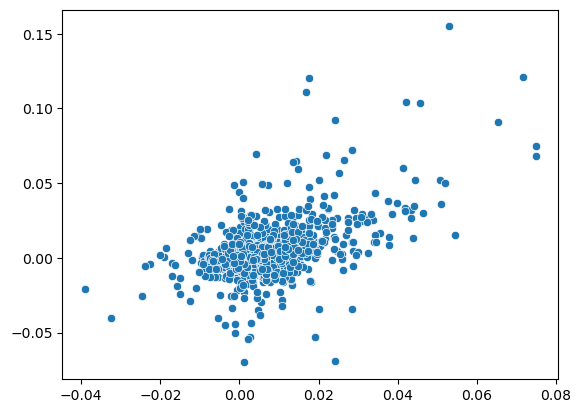

In [17]:
df_new = pd.read_csv(os.path.join(DATA_DIRECTORY, 'selection-nonsyn-paper.csv'))
df_old = pd.read_csv(os.path.join(DATA_DIRECTORY, 'selection-g40-1pct-nonsyn-paper.csv'))

s_new = []
s_old = []

for idx, row in df_old.iterrows():
    df_sel = df_new[(df_new['nucleotide number']==str(row['nucleotide number'])) & (df_new['nucleotide']==row['nucleotide'])]
    if len(df_sel)==1:
        s_old.append(row['selection coefficient'])
        s_new.append(df_sel.iloc[0]['selection coefficient'])
    if len(df_sel)>1:
        print('Found multiple matches!')
        print(df_sel.head())

s_new = np.array(s_new)
s_old = np.array(s_old)

import seaborn as sns

sns.scatterplot(x=s_old, y=s_new)

In [18]:
print(st.pearsonr(s_new, s_old))
print(st.spearmanr(s_new, s_old))

PearsonRResult(statistic=0.5150046402103325, pvalue=2.3639591849355113e-77)
SignificanceResult(statistic=0.37676197762468944, pvalue=2.505264805497345e-39)


In [21]:
print(np.sum(s_old>0.02))
print(np.sum((s_old>0.02)*(s_new>0.02)))
50/88

88
50


0.5681818181818182

### Metadata testing

In [ ]:
df = pd.read_csv('data/metadata.tsv', sep='\t')

In [22]:
df.columns

Index(['Virus name', 'Last vaccinated', 'Passage details/history', 'Type',
       'Accession ID', 'Collection date', 'Location',
       'Additional location information', 'Sequence length', 'Host',
       'Patient age', 'Gender', 'Clade', 'Pango lineage', 'Pango version',
       'Variant', 'AA Substitutions', 'Submission date', 'Is reference?',
       'Is complete?', 'Is high coverage?', 'Is low coverage?', 'N-Content',
       'GC-Content'],
      dtype='object')

In [18]:
np.unique(df.astype({'Location': 'str'})['Variant'])

array(['Former VOC Alpha GRY (B.1.1.7+Q.*) first detected in the UK',
       'Former VOC Beta GH/501Y.V2 (B.1.351+B.1.351.2+B.1.351.3) first detected in South Africa',
       'Former VOC Delta GK (B.1.617.2+AY.*) first detected in India',
       'Former VOC Gamma GR/501Y.V3 (P.1+P.1.*) first detected in Brazil/Japan',
       'Former VOC Omicron GRA (B.1.1.529+BA.*) first detected in Botswana/Hong Kong/South Africa',
       'Former VOI Epsilon GH/452R.V1 (B.1.429+B.1.427) first detected in USA/California',
       'Former VOI Eta G/484K.V3 (B.1.525) first detected in UK/Nigeria',
       'Former VOI Iota GH/253G.V1 (B.1.526) first detected in USA/New York',
       'Former VOI Kappa G/452R.V3 (B.1.617.1) first detected in India',
       'Former VOI Lambda GR/452Q.V1 (C.37+C.37.1) first detected in Peru',
       'Former VOI Mu GH (B.1.621+B.1.621.1) first detected in Colombia',
       'Former VOI Theta GR/1092K.V1 (P.3) first detected in the Philippines',
       'Former VOI Zeta GR/484K.V2 

In [20]:
# df_sub = df[(df['Is complete?']==True) & (df['Is high coverage?']==True) & (df['Host']=='Human')]
df_sub = df[df['Host']=='Human']
df_sub = df_sub.drop(columns=['Virus name', 'Last vaccinated', 'Passage details/history', 'Type', 
                              'Additional location information', 'Sequence length', 'Host',
                              'Patient age', 'Gender', 'Clade', 'Is reference?', 'Is complete?', 
                              'Is high coverage?', 'Is low coverage?', 'N-Content', 'GC-Content'])
len(df_sub)

16517164

In [21]:
def compress_location(loc_list):
    c_locs = []
    for loc in loc_list:
        loc_split = loc.replace(' ', '').replace(',', '').split('/')
        if len(loc_split)<2:
            c_locs.append('')
        elif loc_split[1]=='USA':
            if len(loc_split)<3:
                c_locs.append('')
            else:
                c_locs.append('-'.join(loc_split[0:3]))
        else:
            c_locs.append('-'.join(loc_split[0:2]))
    return c_locs

In [22]:
df_sub['Compressed location'] = compress_location(df_sub['Location'])

In [4]:
import datetime as dt
t_ref = dt.date(2020, 1, 1)

def get_time(t_list):
    t = []
    for time in t_list:
        t_split = time.split('-')
        if len(t_split)<3:
            t.append(-1)
        else:
            t_sample = dt.date(int(t_split[0]), int(t_split[1]), int(t_split[2]))
            t.append((t_sample - t_ref).days)
    return t

In [24]:
df_sub['Time'] = get_time(df_sub['Collection date'])

In [25]:
df_sub = df_sub[df_sub['Time']>0]
df_sub.to_csv('data/compressed-metadata.csv.gz', index=False)

In [3]:
df_sub = pd.read_csv('data/compressed-metadata.csv.gz')
df_sub.columns

Index(['Accession ID', 'Collection date', 'Location', 'Pango lineage',
       'Pango version', 'Variant', 'AA Substitutions', 'Submission date',
       'Compressed location', 'Time'],
      dtype='object')

In [5]:
locs = np.unique(df_sub['Compressed location'].astype(str))

In [88]:
gb_regions = ['Europe / United Kingdom', 'Europe / United Kingdom / England', 'Europe / United Kingdom / Scotland', 'Europe / United Kingdom / Wales']

df_uk = df_sub[df_sub['Compressed location']=='Europe-UnitedKingdom']
df_uk = df_uk[(df_uk['Time']>200) & (df_uk['Time']<349)]
df_gb = df_uk[df_uk['Location'].isin(gb_regions)]

In [89]:
df_gb['Subtime'] = get_time(df_gb['Submission date'])

/var/folders/s6/r0hv0w_j5pnbjrpqcsn9sq8m0000gp/T/ipykernel_82790/3701825226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gb['Subtime'] = get_time(df_gb['Submission date'])


In [90]:
df_alpha = df_gb[df_gb['Variant']=='Former VOC Alpha GRY (B.1.1.7+Q.*) first detected in the UK']
df_other = df_gb[df_gb['Variant']!='Former VOC Alpha GRY (B.1.1.7+Q.*) first detected in the UK']

In [91]:
dt_alpha = df_alpha['Subtime']-df_alpha['Time']
dt_other = df_other['Subtime']-df_other['Time']

In [92]:
df_alpha_fast = df_alpha[(df_alpha['Subtime']-df_alpha['Time'])<45]
df_other_fast = df_other[(df_other['Subtime']-df_other['Time'])<45]

In [93]:
dt_alpha_fast = df_alpha_fast['Subtime']-df_alpha_fast['Time']
dt_other_fast = df_other_fast['Subtime']-df_other_fast['Time']

20.199900216198238
0.32379843672043906


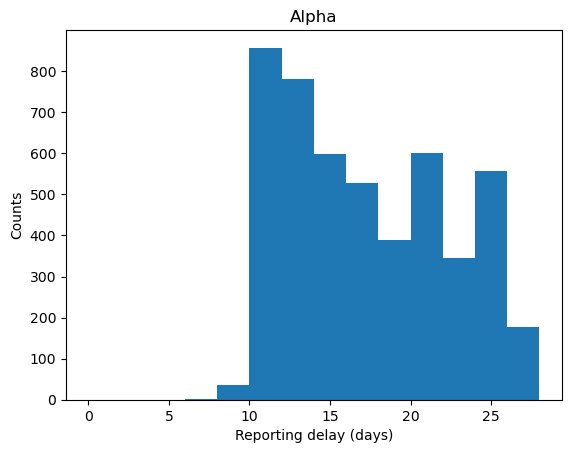

In [94]:
bins = np.arange(0, 30, 2)
plt.hist(dt_alpha_fast, bins)
print(np.mean(dt_alpha_fast))
print(np.sum(dt_alpha_fast<15)/len(dt_alpha_fast))
plt.title('Alpha')
plt.xlabel('Reporting delay (days)')
plt.ylabel('Counts')
plt.savefig('alpha-delay.pdf')

23.051898908357032
0.0508210255939822


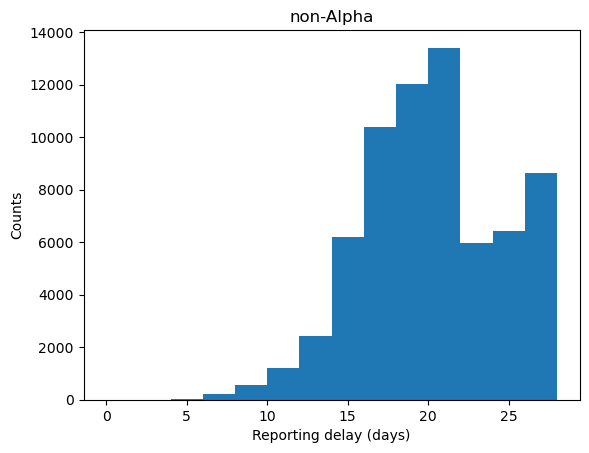

In [95]:
plt.hist(dt_other_fast, bins)
print(np.mean(dt_other_fast))
print(np.sum(dt_other_fast<14)/len(dt_other_fast))
plt.title('non-Alpha')
plt.xlabel('Reporting delay (days)')
plt.ylabel('Counts')
plt.savefig('non-alpha-delay.pdf')

In [5]:
gb_regions = ['Europe / United Kingdom', 'Europe / United Kingdom / England', 'Europe / United Kingdom / Scotland', 'Europe / United Kingdom / Wales']

df_uk = df_sub[df_sub['Compressed location']=='Europe-UnitedKingdom']
df_uk = df_uk[(df_uk['Time']>456) & (df_uk['Time']<487)]
df_gb = df_uk[df_uk['Location'].isin(gb_regions)]

In [6]:
df_gb['Subtime'] = get_time(df_gb['Submission date'])

/var/folders/s6/r0hv0w_j5pnbjrpqcsn9sq8m0000gp/T/ipykernel_2479/3701825226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gb['Subtime'] = get_time(df_gb['Submission date'])


In [9]:
df_delta = df_gb[df_gb['Variant']=='Former VOC Delta GK (B.1.617.2+AY.*) first detected in India']
df_other = df_gb[df_gb['Variant']!='Former VOC Delta GK (B.1.617.2+AY.*) first detected in India']

dt_delta = df_delta['Subtime']-df_delta['Time']
dt_other = df_other['Subtime']-df_other['Time']

df_delta_fast = df_delta[(df_delta['Subtime']-df_delta['Time'])<45]
df_other_fast = df_other[(df_other['Subtime']-df_other['Time'])<45]

dt_delta_fast = df_delta_fast['Subtime']-df_delta_fast['Time']
dt_other_fast = df_other_fast['Subtime']-df_other_fast['Time']

12.422222222222222
0.7266666666666667


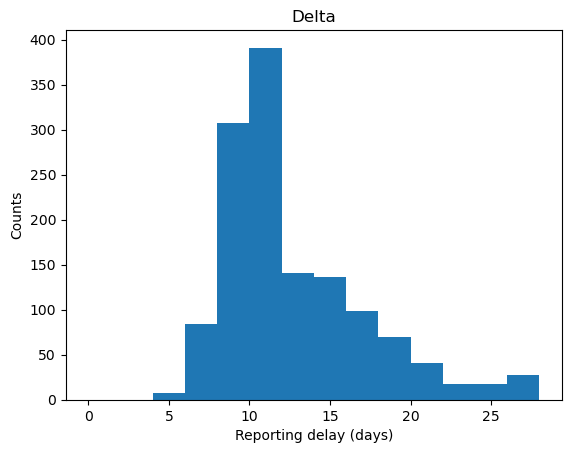

In [10]:
bins = np.arange(0, 30, 2)
plt.hist(dt_delta_fast, bins)
print(np.mean(dt_delta_fast))
print(np.sum(dt_delta_fast<15)/len(dt_delta_fast))
plt.title('Delta')
plt.xlabel('Reporting delay (days)')
plt.ylabel('Counts')
plt.savefig('delta-delay.pdf')

11.858706054999043
0.7683595993109169


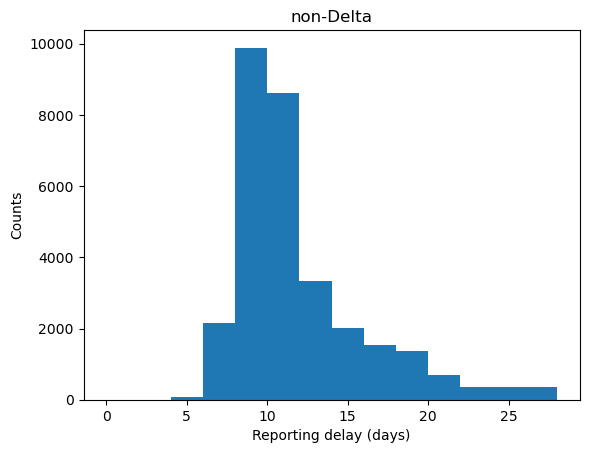

In [11]:
plt.hist(dt_other_fast, bins)
print(np.mean(dt_other_fast))
print(np.sum(dt_other_fast<14)/len(dt_other_fast))
plt.title('non-Delta')
plt.xlabel('Reporting delay (days)')
plt.ylabel('Counts')
plt.savefig('non-delta-delay.pdf')

# Paper figures

In [3]:
# Figure 1 -- inference results for simulations

import figs as f
reload(f)

data = { 'sim_file':       os.path.join(SIMULATION_DIRECTORY, 'sim-init-sample50-T50.npz'),
         'inf_file':       os.path.join(SIMULATION_DIRECTORY, 'inf-init-sample50-T50.npz'),
         'replicate_file': os.path.join(SIMULATION_DIRECTORY, 'epi-init-sample50-T50.npz'),
         'pop_size':       10000,
         'cutoff':         0.01 }

f.plot_performance(**data)

In [4]:
# Figure 2 -- aggregate statistics for inferred coefficients

import figs as f
reload(f)
        
data = { #'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection-nonsyn-paper.csv'),
         #'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection-nonsyn-collapsed-paper.csv'),
         # 'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection_coefficients_corrected_paper.csv'),
         # 'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection_coefficients_corrected_paper.csv'),
         'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
         'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
         'label2ddr':          { 'NSP1':  0.01,
                                 'NSP2':  0.02,
                                 'NSP7':  0.09,
                                 'NSP13': 0.03,
                                 'E':     0.09,
                                 'ORF6':  0.12,
                                 'ORF7a': 0.09,
                                 'ORF7b': 0.08,
                                 'ORF8':  0.03,
                                 'ORF10': 0.01 } }

f.plot_selection_statistics_extended(**data)

In [6]:
df = pd.read_csv('data/phenotype-table-new.csv')

var_cols = ['Epsilon', 'Alpha', 'Beta', 'Lambda', 'Gamma', 'Mu', 'Delta', 
            'BA.1', 'BA.2', 'BA.4', 'BA.5', 'XBB', 'XBB.1.5', 'EG.5.1', 'BA.2.86', 'JN.1']

for idx, entry in df.iterrows():
    for v in var_cols:
        var_list = list(str(entry['Associated variants']).split())
        if v in var_list or df.at[idx, v]==True:
            df.at[idx, v] = True
        else:
            if v=='BA.2' and (('BA.2.12.1' in var_list) or ('BA.2.75' in var_list)):
                df.at[idx, v] = True
            else:
                df.at[idx, v] = False

df.to_csv('data/phenotype-table-new-corrected.csv', index=False)

In [70]:
import figs as f
reload(f)
        
data = { #'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection-nonsyn-paper.csv'),
         #'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection-nonsyn-collapsed-paper.csv'),
         # 'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection_coefficients_corrected_paper.csv'),
         # 'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection_coefficients_corrected_paper.csv'),
         'selection_file_all': os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
         'selection_file_ns':  os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'),
         'mutation_file':      os.path.join(SARS_DATA_DIR, 'phenotype-table-new-corrected.csv'),
         'label2ddr':          { 'NSP1':  0.01,
                                 'NSP2':  0.02,
                                 'NSP7':  0.09,
                                 'NSP13': 0.03,
                                 'E':     0.09,
                                 'ORF6':  0.12,
                                 'ORF7a': 0.09,
                                 'ORF7b': 0.08,
                                 'ORF8':  0.03,
                                 'ORF10': 0.01 } }

f.plot_selection_statistics_mutations(**data)

In [7]:
# Selection coefficients and ranks for specific mutations

df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-nonsyn-paper.csv'), memory_map=True)
# df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'), memory_map=True)

print('We estimate selection coefficients for %d nonsynonymous single nucleotide variants\n' % len(df))


# df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-nonsyn-collapsed-paper.csv'), memory_map=True)
df = pd.read_csv(os.path.join(SARS_DATA_DIR, 'selection-nonsyn-corrected.csv'), memory_map=True)

names = ['NSP6:d106', 'NSP6:d107', 'NSP6:d108', 'S:E484K ', 'S:S477N ', 'S:N501Y ', 'S:D614G ', 'N:R203M ']
idxs  = [      11288,       11291,       11294,      23012,      22992,      23063,      23403,      28881]
nucs  = [        '-',         '-',         '-',        'A',        'A',        'T',        'G',        'T']

names = names + ['N:T205I ', 'N:S202N ', 'N:S202R ', 'ORF7a:T120I', 'M:I82T  ', 'S:A222V ']
idxs  = idxs  + [     28887,      28878,      28879,         27752,      26767,      22227]
nucs  = nucs  + [       'T',        'A',        'G',           'T',        'C',        'T']

print('name\t\ts\trank')
for i in range(len(names)):
    df_temp = df[(df['nucleotide number']==str(idxs[i])) & (df['nucleotide']==nucs[i])]
    if len(df_temp)>0:
        print('%s\t%.3f\t%d' % (names[i], df_temp.iloc[0]['selection coefficient'], 
                                1 + np.sum(df['selection coefficient']>df_temp.iloc[0]['selection coefficient'])))

topx  = 5
order = np.argsort(np.array(df['selection coefficient']))[::-1] 
print('\nname\t\ts\trank')
for i in range(topx):
    df_temp = df.iloc[order[i]]
    name = df_temp['protein']+':'+df_temp['amino acid mutation'].split('>')[0]+df_temp['amino acid number in protein'] \
           +df_temp['amino acid mutation'].split('>')[1]
    if len(name)<9:
        name = name+'\t'
    print('%s\t%.3f\t%d' % (name, df_temp['selection coefficient'], i+1))

We estimate selection coefficients for 1259 nonsynonymous single nucleotide variants

name		s	rank
NSP6:d106	0.153	1
NSP6:d107	-0.019	788
NSP6:d108	0.008	241
S:E484K 	0.032	64
S:S477N 	0.046	43
S:N501Y 	0.083	13
N:R203M 	0.083	12
N:T205I 	-0.007	666
N:S202R 	0.002	404
ORF7a:T120I	0.004	322
M:I82T  	0.023	83
S:A222V 	0.000	438

name		s	rank
NSP6:S106-	0.153	1
S:F486L		0.127	2
S:Q498R		0.123	3
S:R346T		0.119	4
NSP4:T492I	0.117	5


In [71]:
# Figure 3 -- selection and trajectories for variants

import figs as f
reload(f)

# data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients.csv'),
#          'trajectory_file': os.path.join(SARS_DATA_DIR, 'linked-trajectories.csv'),
#          'variant_list':    ['alpha', 'delta', 'BA.1', 'BA.2', 'BA.2.12.1', 'BA.5', 'BA.4'],
#          'variant_names':   ['Alpha', 'Delta', 'Omicron (BA.1)', 'BA.2', 'BA.2.12.1', 'BA.5', 'BA.4'],
#          's_cutoff':        0.05,
#          'h_relative':      1/1.1,
#          'time_set':        'late',
#          'filename':        'fig-3' }

data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients-test.csv'),
         'trajectory_file': os.path.join(SARS_DATA_DIR, 'trajectories.csv'),
         'variant_list':    ['alpha', 'delta', 'gamma', 'BA.1', 'BA.2', 'XBB', 'JN.1'], #, 'BA.2.86'],
         'variant_names':   ['Alpha', 'Delta', 'Gamma', 'Omicron (BA.1)', 'BA.2', 'XBB', 'JN.1'], #, 'BA.2.86'],
         's_cutoff':        0.05,
         'h_relative':      1/1.1,
         'time_set':        'current',
         'filename':        'fig-3-new' }

f.plot_variant_selection(**data)

variant	w
JN.1	3.355
XBB	2.802
BA.2	2.127
BA.1	1.702
delta	0.850
gamma	0.423
alpha	0.328


In [72]:
# Figure 4 -- selection over time for the first major VOCs

import figs as f
reload(f)

data = { 'alpha_file':           os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb.csv'),
         'alpha_file_subdate':   os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb-subdate.csv'),
         'alpha_start':          310,
         'alpha_end':            310+57,
         'delta_file':           os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb.csv'),
         'delta_file_subdate':   os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb-subdate.csv'),
         'delta_start':          462,
         'delta_end':            462+57,
         'omicron_file':         os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa.csv'),
         'omicron_file_subdate': os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa-subdate.csv'),
         'omicron_start':        653,
         'omicron_end':          653+57 }

f.plot_frequency_selection(**data)

In [11]:
# Figure 4 -- early detection

import figs as f
reload(f)

data = { #'alpha_file':           os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb.csv'),
         'alpha_file_subdate':   os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb-subdate.csv'),
         'alpha_start':          308,
         'alpha_end':            308+57,
         #'delta_file':           os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb.csv'),
         'delta_file_subdate':   os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb-subdate.csv'),
         'delta_start':          456,
         'delta_end':            456+57,
         #'omicron_file':         os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa.csv'),
         'omicron_file_subdate': os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa-subdate.csv'),
         'omicron_start':        665,
         'omicron_end':          665+57,
         's_cutoff':             0.140 }

f.plot_early_detection_sub(**data)

by submission date
cutoff	statistic	alpha	delta	omicron
0.14	time		326	481	706


# Supplementary Figures

In [50]:
# Variables

import epi_figs as ef

seq_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2020-10-31-2020-12-14---2020-10-31-2020-12-14.csv'
map_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2020-10-31-2020-12-14---2020-10-31-2020-12-14-sites.csv'
var_ref = 'data/variant-mutations.csv'
var_nam = 'Alpha'
t_detect = 332
verbose = False

nuc = ef.NUC
var_frc = 0.8

t_latest = 0  # Look at sequences collected within X days of the latest
dt = 14        

n_latest = 100  # ALT: Look at the latest X sequences as of the detection day

seqs = []
dates = []


# Read in variant mutations

df_var = pd.read_csv(var_ref)
df_var = df_var[df_var[var_nam]==True]
n_muts = len(df_var)
mut_list = list(df_var['mutation'])
var_cutoff = int(var_frc * n_muts)


# Read in sequences and get ones within dt of the most recently submitted sequence at the time of detection

df_seq = pd.read_csv(seq_ref)
df_seq = df_seq[df_seq['submission_date']<=t_detect]

t_latest  = np.max(df_seq['date'])
df_latest = df_seq[df_seq['date']>=t_latest-dt]

for i in range(len(df_latest)):
    seqs.append(str(df_latest.iloc[i]['sequence']))
    dates.append(int(df_latest.iloc[i]['date']))

print('Searching for %s sequences among sequences within %d days of the most recent sequence at time %d before the detection time %d' % (var_nam, dt, t_latest, t_detect))
print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# ALT: Read in sequences and get the n_latest most recently submitted as of the detection time

# df_seq = pd.read_csv(seq_ref)
# df_seq = df_seq[df_seq['submission_date']<=t_detect]

# t_sort = np.argsort(np.array(df_seq['date'], int))[::-1]

# for i in range(n_latest):
#     seqs.append(str(df_seq.iloc[t_sort[i]]['sequence']))
#     dates.append(int(df_seq.iloc[t_sort[i]]['date']))

# print('Searching for %s sequences among last %d sequences collected before the detection time %d' % (var_nam, n_latest, t_detect))
# print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# Read in the site map

df_map = pd.read_csv(map_ref)
map_sites = np.array(df_map['ref_sites'])


# Iterate through sequences and determine the number of Alpha mutations in each sequence

if verbose:
    print('variant\tdate\tmutations')

is_var = []
for i in range(len(seqs)):
    s = seqs[i]
    var_muts = 0
    for j in range(len(s)):
        nuc_id = str(map_sites[j]) + '-' + nuc[int(s[j])]
        if nuc_id in mut_list:
            var_muts += 1
    if var_muts >= var_cutoff:
        is_var.append(1)
    else:
        is_var.append(0)
    if verbose:    
        print('%s\t%d\t%d' % (var_nam, dates[i], var_muts))

if verbose:
    print('')
print('%d out of %d (%.2f%%) sequences classified as variant' % (np.sum(is_var), len(is_var), 100*np.sum(is_var)/len(is_var)))

Searching for Alpha sequences among sequences within 14 days of the most recent sequence at time 325 before the detection time 332
46 variant-defining mutations in total, classified as variant for >=36 mutations

126 out of 3239 (3.89%) sequences classified as variant


In [43]:
print('COMBINE THESE RESULTS WITH PREVIOUS DATA BLOCK AND HARDCODED t_latest TO ESTIMATE FREQUENCIES FOR DELTA')

# Variables

import epi_figs as ef

nuc = ef.NUC

seq_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-04-22-2021-05-31---2021-4-22-2021-5-31.csv'
map_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-04-22-2021-05-31---2021-4-22-2021-5-31-sites.csv'
var_ref = 'data/variant-mutations.csv'
var_nam = 'Delta'
t_detect = 488
verbose = False

nuc = ef.NUC
var_frc = 0.8

t_latest = 0  # Look at sequences collected within X days of the latest
dt = 14        

n_latest = 100  # ALT: Look at the latest X sequences as of the detection day

seqs = []
dates = []


# Read in variant mutations

df_var = pd.read_csv(var_ref)
df_var = df_var[df_var[var_nam]==True]
n_muts = len(df_var)
mut_list = list(df_var['mutation'])
var_cutoff = int(var_frc * n_muts)


# Read in sequences and get ones within dt of the most recently submitted sequence at the time of detection

df_seq = pd.read_csv(seq_ref)
df_seq = df_seq[df_seq['submission_date']<=t_detect]

t_latest  = np.max(df_seq['date'])
df_latest = df_seq[df_seq['date']>=t_latest-dt]

for i in range(len(df_latest)):
    seqs.append(str(df_latest.iloc[i]['sequence']))
    dates.append(int(df_latest.iloc[i]['date']))

print('Searching for %s sequences among sequences within %d days of the most recent sequence at time %d before the detection time %d' % (var_nam, dt, t_latest, t_detect))
print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# ALT: Read in sequences and get the n_latest most recently submitted as of the detection time

# df_seq = pd.read_csv(seq_ref)
# df_seq = df_seq[df_seq['submission_date']<=t_detect]

# t_sort = np.argsort(np.array(df_seq['date'], int))[::-1]

# for i in range(n_latest):
#     seqs.append(str(df_seq.iloc[t_sort[i]]['sequence']))
#     dates.append(int(df_seq.iloc[t_sort[i]]['date']))

# print('Searching for %s sequences among last %d sequences collected before the detection time %d' % (var_nam, n_latest, t_detect))
# print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# Read in the site map

df_map = pd.read_csv(map_ref)
map_sites = np.array(df_map['ref_sites'])


# Iterate through sequences and determine the number of Alpha mutations in each sequence

if verbose:
    print('variant\tdate\tmutations')

is_var = []
for i in range(len(seqs)):
    s = seqs[i]
    var_muts = 0
    for j in range(len(s)):
        nuc_id = str(map_sites[j]) + '-' + nuc[int(s[j])]
        if nuc_id in mut_list:
            var_muts += 1
    if var_muts >= var_cutoff:
        is_var.append(1)
    else:
        is_var.append(0)
    if verbose:    
        print('%s\t%d\t%d' % (var_nam, dates[i], var_muts))

if verbose:
    print('')
print('%d out of %d (%.2f%%) sequences classified as variant' % (np.sum(is_var), len(is_var), 100*np.sum(is_var)/len(is_var)))

COMBINE THESE RESULTS WITH PREVIOUS DATA BLOCK AND HARDCODED t_latest TO ESTIMATE FREQUENCIES FOR DELTA
Searching for Delta sequences among sequences within 14 days of the most recent sequence at time 483 before the detection time 488
33 variant-defining mutations in total, classified as variant for >=26 mutations

109 out of 1548 (7.04%) sequences classified as variant


In [44]:
# Variables

import epi_figs as ef

nuc = ef.NUC

seq_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-03-21-2021-04-22---2021-3-21-2021-4-22.csv'
map_ref = 'data/genome-filtered/europe-united kingdom-england_wales_scotland-2021-03-21-2021-04-22---2021-3-21-2021-4-22-sites.csv'
var_ref = 'data/variant-mutations.csv'
var_nam = 'Delta'
t_detect = 488
verbose = False

nuc = ef.NUC
var_frc = 0.8

t_latest = 0  # Look at sequences collected within X days of the latest
dt = 14        

n_latest = 100  # ALT: Look at the latest X sequences as of the detection day

seqs = []
dates = []


# Read in variant mutations

df_var = pd.read_csv(var_ref)
df_var = df_var[df_var[var_nam]==True]
n_muts = len(df_var)
mut_list = list(df_var['mutation'])
var_cutoff = int(var_frc * n_muts)


# Read in sequences and get ones within dt of the most recently submitted sequence at the time of detection

df_seq = pd.read_csv(seq_ref)
df_seq = df_seq[df_seq['submission_date']<=t_detect]

t_latest  = 483
df_latest = df_seq[df_seq['date']>=t_latest-dt]

for i in range(len(df_latest)):
    seqs.append(str(df_latest.iloc[i]['sequence']))
    dates.append(int(df_latest.iloc[i]['date']))

print('Searching for %s sequences among sequences within %d days of the most recent sequence at time %d before the detection time %d' % (var_nam, dt, t_latest, t_detect))
print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# ALT: Read in sequences and get the n_latest most recently submitted as of the detection time

# df_seq = pd.read_csv(seq_ref)
# df_seq = df_seq[df_seq['submission_date']<=t_detect]

# t_sort = np.argsort(np.array(df_seq['date'], int))[::-1]

# for i in range(n_latest):
#     seqs.append(str(df_seq.iloc[t_sort[i]]['sequence']))
#     dates.append(int(df_seq.iloc[t_sort[i]]['date']))

# print('Searching for %s sequences among last %d sequences collected before the detection time %d' % (var_nam, n_latest, t_detect))
# print('%d variant-defining mutations in total, classified as variant for >=%d mutations\n' % (n_muts, var_cutoff))


# Read in the site map

df_map = pd.read_csv(map_ref)
map_sites = np.array(df_map['ref_sites'])


# Iterate through sequences and determine the number of Alpha mutations in each sequence

if verbose:
    print('variant\tdate\tmutations')

is_var = []
for i in range(len(seqs)):
    s = seqs[i]
    var_muts = 0
    for j in range(len(s)):
        nuc_id = str(map_sites[j]) + '-' + nuc[int(s[j])]
        if nuc_id in mut_list:
            var_muts += 1
    if var_muts >= var_cutoff:
        is_var.append(1)
    else:
        is_var.append(0)
    if verbose:    
        print('%s\t%d\t%d' % (var_nam, dates[i], var_muts))

if verbose:
    print('')
print('%d out of %d (%.2f%%) sequences classified as variant' % (np.sum(is_var), len(is_var), 100*np.sum(is_var)/len(is_var)))

Searching for Delta sequences among sequences within 14 days of the most recent sequence at time 483 before the detection time 488
33 variant-defining mutations in total, classified as variant for >=26 mutations

217 out of 7238 (3.00%) sequences classified as variant


In [45]:
(217 + 109)/(7238 + 1548)

0.037104484407011154

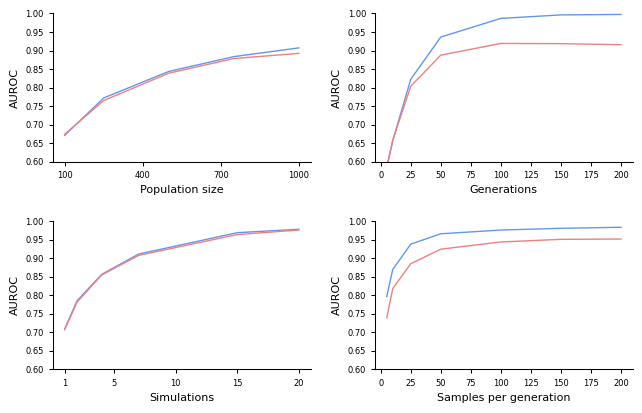

In [11]:
# Supplementary Figure 1 -- AUROC plots for various parameters 

import epi_figs as ef
reload(ef)

ef.auroc_plots_combined(os.path.join(SIMULATION_DIRECTORY, 'epi-init-sim'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-T'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-sample'), 
                        os.path.join(SIMULATION_DIRECTORY, 'epi-init-smallpop'))

In [3]:
# Figure S4 -- selection and trajectories for variants

import figs as f
reload(f)

# data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients.csv'),
#          'trajectory_file': os.path.join(SARS_DATA_DIR, 'linked-trajectories.csv'),
#          'variant_list':  ['alpha', 'delta',           'BA.1', 'BA.2', 'BA.2.12.1', 'BA.5', 'BA.4', 'gamma', 'beta', 'lambda', 'epsilon'],
#          'variant_names': ['Alpha', 'Delta', 'Omicron (BA.1)', 'BA.2', 'BA.2.12.1', 'BA.5', 'BA.4', 'Gamma', 'Beta', 'Lambda', 'Epsilon'],
#          's_cutoff':        0.05,
#          'h_relative':      1/1.1 * (11/7),
#          'time_set':        'late',
#          'filename':        'fig-s4-variants-full' }

data = { 'variant_file':    os.path.join(SARS_DATA_DIR, 'linked-coefficients-test.csv'),
         'trajectory_file': os.path.join(SARS_DATA_DIR, 'trajectories.csv'),
         'variant_list':    ['alpha', 'delta',           'BA.1', 'BA.2', 'BA.4', 'BA.5', 'JN.1', 'BA.2.86', 'XBB', 'XBB.1.5', 'EG.5.1', 'gamma', 'beta', 'lambda', 'epsilon', 'mu'],
         'variant_names':   ['Alpha', 'Delta', 'Omicron (BA.1)', 'BA.2', 'BA.4', 'BA.5', 'JN.1', 'BA.2.86', 'XBB', 'XBB.1.5',   'EG.5', 'Gamma', 'Beta', 'Lambda', 'Epsilon', 'Mu'],
         's_cutoff':        0.05,
         'h_relative':      1 * (16/7),
         'box_dims':        dict(left=0.08, right=0.95, bottom=0.07, top=0.98),
         'time_set':        'current',
         'filename':        'fig-s4-variants-full-new' }

f.plot_variant_selection(**data)

variant	w
JN.1	3.355
BA.2.86	3.273
EG.5.1	3.026
XBB.1.5	2.999
XBB	2.802
BA.5	2.543
BA.4	2.435
BA.2	2.127
BA.1	1.702
delta	0.850
mu	0.451
gamma	0.423
lambda	0.419
beta	0.357
alpha	0.328
epsilon	0.137
JN.1	0.021
BA.2.86	0.021
EG.5	0.022
XBB.1.5	0.022
XBB	0.021
BA.5	0.024
BA.4	0.020
BA.2	0.021
Omicron (BA.1)	0.017
Delta	0.026
Mu	0.015
Gamma	0.011
Lambda	0.009
Beta	0.010
Alpha	0.007
Epsilon	0.011


In [6]:
# Figure S6 -- precision

import figs as f
reload(f)

data = { 'detection_file': os.path.join(SARS_DATA_DIR, 'detection-summary.csv'),
         'fig_title':      'fig-s6-precision' }

f.plot_precision(**data)

In [13]:
# Figure S7 -- early detection

import figs as f
reload(f)

data = { 'alpha_file':    os.path.join(SARS_DATA_DIR, 'alpha-tv-s-gb.csv'),
         'alpha_file_2':  os.path.join(SARS_DATA_DIR, 'alpha-tv-s-london.csv'),
         'alpha_start':   308,
         'alpha_end':     308+57,
         'delta_file':    os.path.join(SARS_DATA_DIR, 'delta-tv-s-gb.csv'),
         'delta_start':   456,
         'delta_end':     456+57,
         'omicron_file':  os.path.join(SARS_DATA_DIR, 'omicron-tv-s-south-africa.csv'),
         'omicron_start': 665,
         'omicron_end':   665+57 }

f.plot_early_detection_col(**data)

#plot_early_detection_old(null_file, alpha_file, alpha_start, alpha_end, delta_file, delta_start, delta_end, omicron_file, omicron_start, omicron_end)

by collection time
cutoff	statistic	alpha (gb)	alpha (london)	delta	omicron
0.18	time		352		321		473	671
0.18	freq		0.063		0.048		0.030	0.028



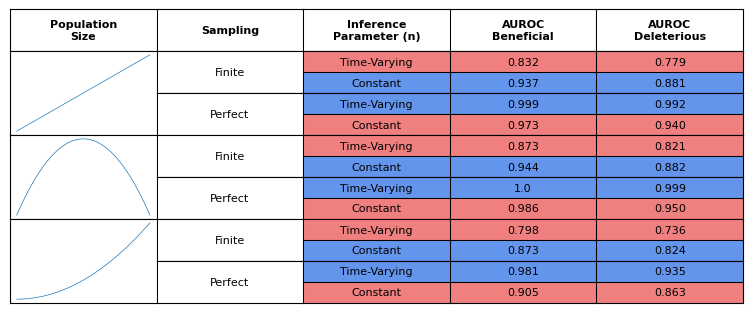

In [10]:
# Supplementary Figure 9 -- finite sampling and time-varying versus constant parameters

import epi_figs as ef
reload(ef)

rep_finite_dir = os.path.join(SIMULATION_DIRECTORY, 'replicates-finite')
rep_perfect_dir = os.path.join(SIMULATION_DIRECTORY, 'replicates-perfect')
ef.finite_sampling_plot(rep_finite_dir, rep_perfect_dir)

number of regions is 126
maximum sequences in region /Users/jpb156/Dropbox/git/paper-SARS-CoV-2-inference-temp/data/genome-filtered-out/europe-united kingdom-england_wales_scotland.csv is 15425


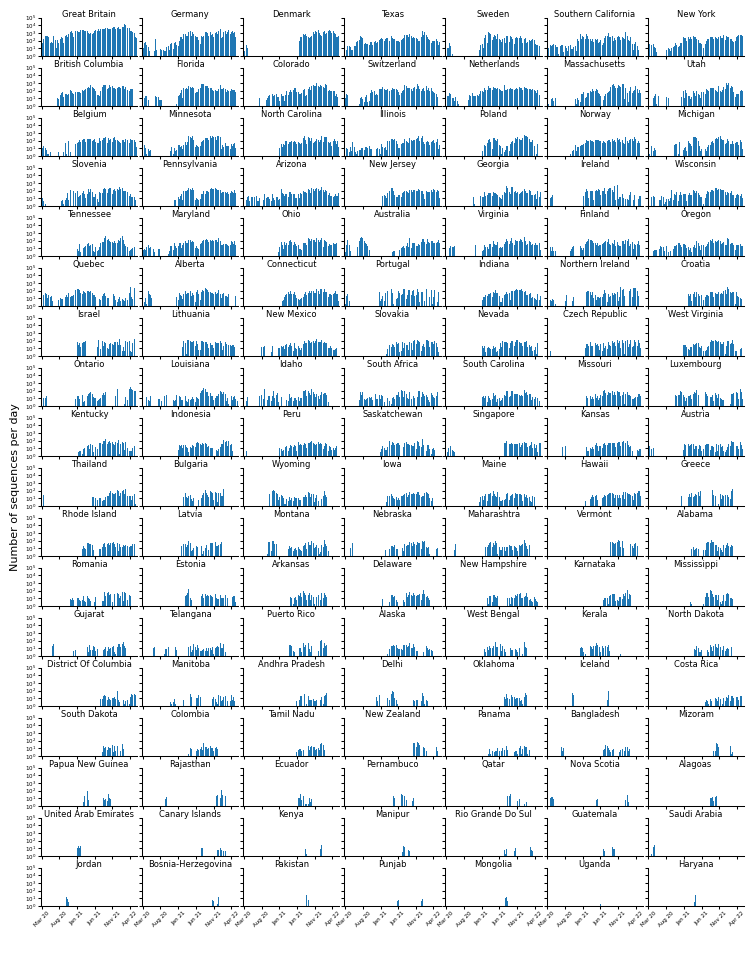

In [11]:
# Supplementary Figure 10 -- sampling distributions in different regions

import epi_figs as ef
reload(ef)

sampling_dir = os.path.join(SARS_DATA_DIR, 'genome-filtered')
gen_dir      = os.path.join(SARS_DATA_DIR, 'genome-filtered-out')
ef.sampling_plots(sampling_dir, gen_dir, save_temp=False, log=True, out_file='fig-s12-sampling')

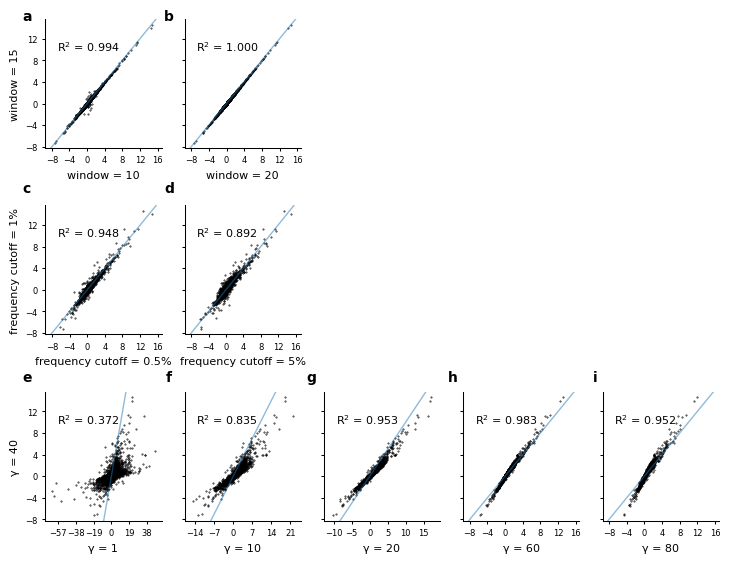

In [12]:
# Supplementary Figure 11 -- checks for how inferred coefficients change as various model or data analysis 
# parameters are changed

import epi_figs as ef
reload(ef)

inf_dir = os.path.join(SARS_DATA_DIR, 'sensitivity-data')
if not os.path.exists(inf_dir):
    os.mkdir(inf_dir)
file1   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-40.npz')
file2   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-1.npz')
file3   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-10.npz')
file4   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-20.npz')
file5   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-60.npz')
file6   = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-80.npz')
files   = [file1, file2, file3, file4, file5, file6]
labels  = ['\u03B3 = 40', '\u03B3 = 1', '\u03B3 = 10', '\u03B3 = 20', '\u03B3 = 60', '\u03B3 = 80']

file_cut1 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-40.npz')
file_cut2 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-0.5pct.npz')
file_cut3 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-5pct.npz')
files_cut = [file_cut1, file_cut2, file_cut3]
label_cut = ['frequency cutoff = 1%', 'frequency cutoff = 0.5%', 'frequency cutoff = 5%']

file_wind1 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-observed-g-40.npz')
file_wind2 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-dt-10.npz')
file_wind3 = os.path.join(inf_dir, f'infer-{INFERENCE_DATE}-dt-20.npz')
files_wind = [file_wind1, file_wind2, file_wind3]
label_wind = ['window = 15', 'window = 10', 'window = 20']

reload(ef)
ef.s_compare_regs_cutoff_window(files_reg=files, labels_reg=labels, 
                                files_cutoff=files_cut, labels_cutoff=label_cut, 
                                files_wind=files_wind, labels_wind=label_wind,
                                out='fig-s13-sensitivity')

there are 410 selection coefficients


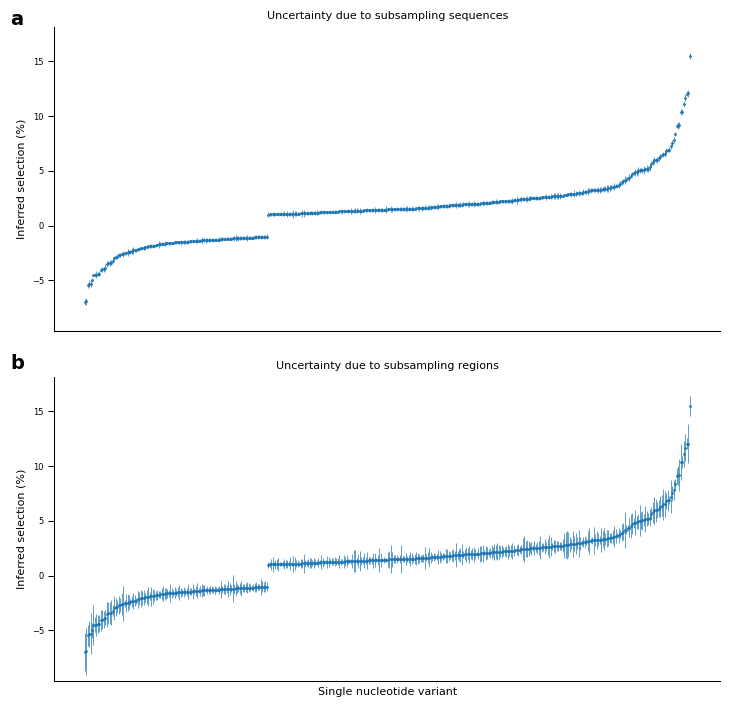

In [13]:
# Supplementary figure Y -- Plots of errors from subsampling regions and subsampling sequences

import epi_figs as ef
reload(ef)

bootstrap_file = os.path.join(SARS_DATA_DIR, 'selection-nonsyn-bootstrap.csv')
subsample_file = os.path.join(SARS_DATA_DIR, 'selection-nonsyn-subsample.csv')
ef.selection_error(bs_data=bootstrap_file, ss_data=subsample_file, out='fig-s14-uncertainty')

['N-3-1-C', 'N-3-2-T', 'N-3-3-A', 'N-235-2-T', 'NSP12-912-3-C', 'NSP12-613-3-T', 'NSP12-412-3-T', 'NSP2-36-3-T', 'NSP3-890-2-A', 'NSP3-183-2-T', 'NSP3-1412-2-C', 'NSP3-1089-3-T', 'ORF8-73-2-G', 'ORF8-52-2-T', 'ORF8-27-1-T', 'S-982-1-G', 'S-716-2-T', 'S-570-2-A', 'S-501-1-T', 'S-1118-1-C']
['N-3-1-C', 'N-3-2-T', 'N-3-3-A', 'N-235-2-T', 'NSP12-912-3-C', 'NSP12-613-3-T', 'NSP12-412-3-T', 'NSP2-36-3-T', 'NSP3-890-2-A', 'NSP3-183-2-T', 'NSP3-1412-2-C', 'NSP3-1089-3-T', 'ORF8-73-2-G', 'ORF8-52-2-T', 'ORF8-27-1-T', 'S-982-1-G', 'S-716-2-T', 'S-570-2-A', 'S-501-1-T', 'S-1118-1-C']
['M-82-2-C', 'N-63-2-G', 'N-377-1-T', 'N-203-2-T', 'NC-209-T', 'NSP12-671-1-A', 'NSP13-77-2-T', 'ORF3a-26-2-T', 'ORF7a-82-2-C', 'ORF7a-120-2-T', 'S-950-1-A', 'S-681-2-G', 'S-478-2-A', 'S-452-2-G', 'S-19-2-G']
['M-82-2-C', 'N-63-2-G', 'N-377-1-T', 'N-203-2-T', 'NC-209-T', 'NSP12-671-1-A', 'NSP13-77-2-T', 'ORF3a-26-2-T', 'ORF7a-82-2-C', 'ORF7a-120-2-T', 'S-950-1-A', 'S-681-2-G', 'S-478-2-A', 'S-452-2-G', 'S-19-2-G']
['

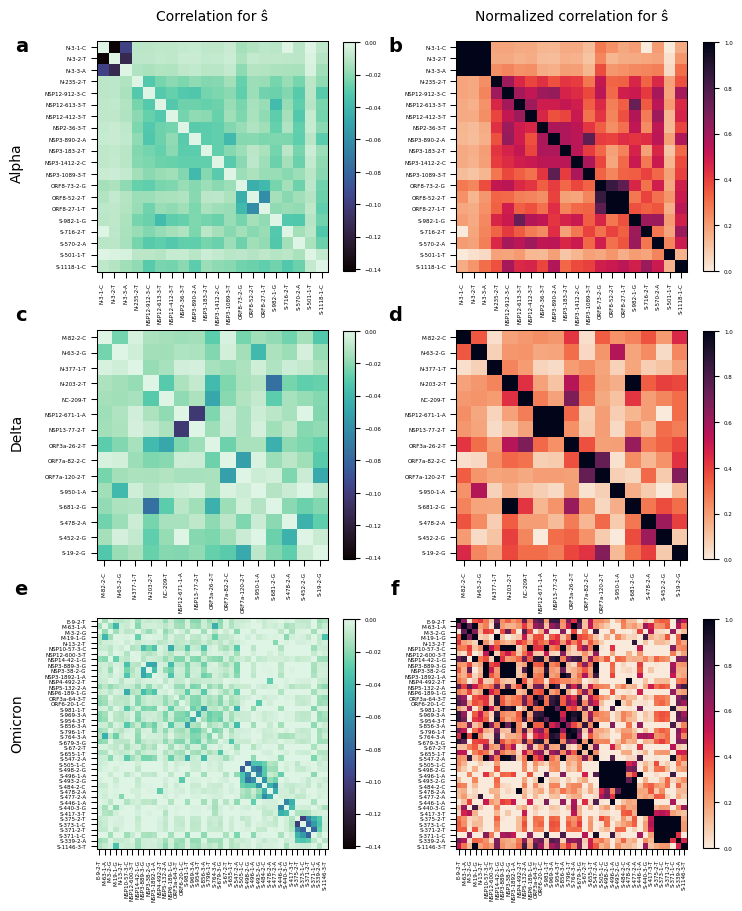

In [14]:
# Supplementary figure Z -- Matrix correlation plots

import epi_figs as ef
reload(ef)

cm_to_inch = lambda x: x/2.54
DOUBLE_COLUMN_WIDTH = cm_to_inch(19)

alpha_cor    = os.path.join(SARS_DATA_DIR, f'alpha-correlation-{INFERENCE_DATE}.csv')
alpha_norm   = os.path.join(SARS_DATA_DIR, f'alpha-correlation-normed-{INFERENCE_DATE}.csv')
delta_cor    = os.path.join(SARS_DATA_DIR, f'delta-correlation-{INFERENCE_DATE}.csv')
delta_norm   = os.path.join(SARS_DATA_DIR, f'delta-correlation-normed-{INFERENCE_DATE}.csv')
omicron_cor  = os.path.join(SARS_DATA_DIR, f'omicron-correlation-{INFERENCE_DATE}.csv')
omicron_norm = os.path.join(SARS_DATA_DIR, f'omicron-correlation-normed-{INFERENCE_DATE}.csv')
params = {
    'files'    : [[alpha_cor,     alpha_norm], 
                  [delta_cor,     delta_norm],
                  [omicron_cor, omicron_norm]],
    'titles'   : ['Correlation for s\u0302', 'Normalized correlation for s\u0302'],
    'variants' : ['Alpha', 'Delta', 'Omicron'],
    'figsize'  : [DOUBLE_COLUMN_WIDTH, DOUBLE_COLUMN_WIDTH * 1.2],
    'out'      : 'fig-s15-matrices'
}

ef.matrix_multiplot_new(**params)

In [ ]:
# Supplementary figure X -- Frequency comparison of Alpha and Gamma

# import epi_figs as ef
# reload(ef)

# variants  = ['Alpha', 'Gamma']
# sites     = [['S-570-1-A', 'S-716-1-T', 'S-982-0-G', 'S-1118-0-C'],
#              ['S-20-1-A', 'S-190-2-T', 'S-1027-1-T', 'N-80-1-G']]

# add_vars  = ['Delta']
# add_sites = [['S-158-0--', 'N-63-1-G', 'S-19-1-G', 'ORF7a-82-1-C']]

# inf_file  = os.path.join(SARS_DATA_DIR, 'infer-2021-08-14-g-60.npz')

# args = {'file' : inf_file, 
#         'variants' : variants,
#         'var_sites' : sites,
#         'add_vars' : add_vars,
#         'add_sites' : add_sites,
#         'min_length' : 25,
#         'out' : 'alpha-gamma-traj'}

# ef.plot_variant_traj(**args)

In [ ]:
# Table 1 -- selection coefficients for mutations

import epi_figs as ef
reload(ef)

out = os.path.join(SARS_DATA_DIR, f'selection-table-{INFERENCE_DATE}')
ef.selection_table(os.path.join(SARS_DATA_DIR, 'selection-nonsyn-subsample-corrected.csv'), out=out)

In [ ]:
# Table 2 -- selection coefficients for major variants of concern

import epi_figs as ef
reload(ef)

ef.variant_selection_table(os.path.join(SARS_DATA_DIR, 'linked-coefficients.csv'), 
                           os.path.join(SARS_DATA_DIR, 'sensitivity-data', 
                                        f'infer-{INFERENCE_DATE}-observed-g-40.npz'))

In [ ]:
# Table 3 -- early detection 

import epi_figs as ef
reload(ef)

file = os.path.join(SARS_DATA_DIR, 'early-detection.csv')
ef.early_detection_table(file)